In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob

In [5]:
images_path = '../input/flickr8k-sau/Flickr_Data/Images/'

In [6]:
def load_images(image_path):
    images = []
    for file_name in os.listdir(image_path):
        img = str(os.path.join(image_path,file_name))
        if img is not None:
            images.append(img)
    return images

In [7]:
images = load_images(images_path)

In [8]:
len(images)

8091

In [9]:
images[0]

'../input/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg'

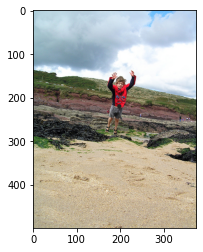

In [10]:
import matplotlib.pyplot as plt

plt.figure()
img = cv2.imread(images[100])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [11]:
from keras.applications.resnet import ResNet50
incept_model =ResNet50(include_top=True)

2022-12-29 10:56:50.379569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 10:56:50.468863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 10:56:50.469771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 10:56:50.471545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
incept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1000:
        break
        
    elif count % 10 == 0:
        print(count)

2022-12-29 10:56:55.117090: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-29 10:56:56.979675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [15]:
#images_feature
len(images_features)

1001

In [16]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [17]:
captions = open(caption_path,'rb').read().decode('utf-8').split('\n')

In [18]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [19]:
#captions_dict
len(captions_dict)

1001

In [20]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

In [21]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [22]:
#captions_dict

In [23]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [24]:
#count_words

In [25]:
len(count_words)

3329

In [26]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1


In [27]:
len(new_dict)
new_dict[''] = len(new_dict) 
captions_backup = captions_dict.copy()
captions_dict = captions_backup.copy()

In [28]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict[''])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded
            

In [29]:
#captions_dict

In [30]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [31]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 2, 11, 12, 13, 14, 15, 6, 2, 16, 17, 18]
[1, 2, 22, 4, 6, 23, 24, 25, 13, 26, 6, 9, 10, 2, 27, 28, 13, 2, 12, 29, 30, 17, 18]
[1, 2, 84, 85, 6, 2, 86, 87, 53, 86, 88, 89, 2, 51, 90, 91, 2, 41, 46, 53, 92, 93, 17, 18]
[1, 23, 66, 6, 23, 86, 52, 19, 472, 2, 464, 465, 287, 2, 61, 166, 23, 66, 6, 23, 145, 448, 473, 120, 474, 468, 113, 17, 18]
[1, 2, 43, 6, 2, 237, 87, 1396, 2, 165, 279, 23, 81, 267, 2, 58, 53, 27, 103, 120, 1519, 452, 2, 51, 53, 27, 103, 111, 29, 17, 18]
[1, 203, 230, 27, 103, 19, 35, 23, 280, 147, 292, 27, 103, 13, 2, 58, 1786, 29, 443, 180, 19, 132, 279, 2, 929, 285, 280, 203, 82, 367, 310, 2, 950, 767, 17, 18]


In [32]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    
    

In [33]:
X, y_in, y_out = generator(images_features, captions_dict)

In [34]:
len(X), len(y_in), len(y_out)

(64404, 64404, 64404)

In [35]:
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [36]:
X.shape,y_in.shape,y_out.shape

((64404, 2048), (64404, 36), (64404, 3330))

In [37]:
from tensorflow.keras.utils import plot_model,to_categorical
from keras.models import Model,Sequential
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,Flatten,Convolution2D,TimeDistributed,Activation,Bidirectional,RepeatVector,Concatenate
from keras.layers.merge import add,Add
from keras.callbacks import ModelCheckpoint



In [38]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 128)           426240    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 128)           32896     
Total params: 853,376
Traina

In [39]:
X.shape,y_in.shape,y_out.shape

((64404, 2048), (64404, 36), (64404, 3330))

In [40]:
model.fit([X, y_in], y_out, batch_size=512, epochs=150)

Epoch 1/150
126/126 [==============================] - 12s 59ms/step - loss: 5.3087 - accuracy: 0.1191
Epoch 2/150
126/126 [==============================] - 7s 58ms/step - loss: 5.1089 - accuracy: 0.1205
Epoch 3/150
126/126 [==============================] - 7s 58ms/step - loss: 5.0053 - accuracy: 0.1219
Epoch 4/150
126/126 [==============================] - 7s 58ms/step - loss: 4.8887 - accuracy: 0.1312
Epoch 5/150
126/126 [==============================] - 8s 60ms/step - loss: 4.5760 - accuracy: 0.1853
Epoch 6/150
126/126 [==============================] - 7s 59ms/step - loss: 4.2726 - accuracy: 0.2433
Epoch 7/150
126/126 [==============================] - 7s 59ms/step - loss: 4.1573 - accuracy: 0.2547
Epoch 8/150
126/126 [==============================] - 7s 59ms/step - loss: 4.0234 - accuracy: 0.2686
Epoch 9/150
126/126 [==============================] - 7s 59ms/step - loss: 3.9248 - accuracy: 0.2756
Epoch 10/150
126/126 [==============================] - 7s 58ms/step - loss: 3.83

In [41]:
inv_dict = {v:k for k, v in new_dict.items()}
model.save('model.h5')
model.save_weights('mine_model_weights.h5')
np.save('vocab.npy', new_dict)

In [42]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

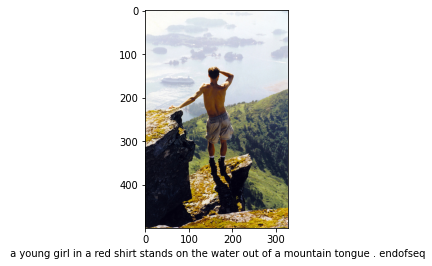

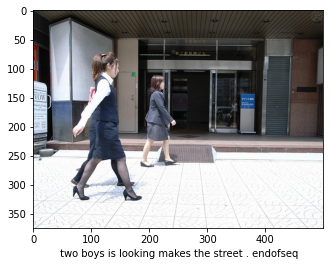

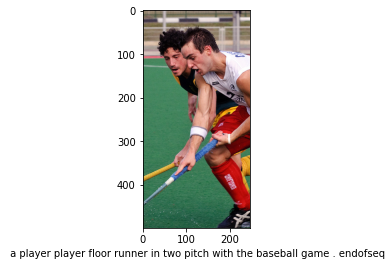

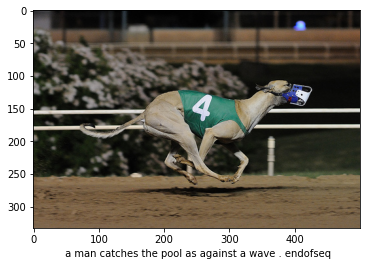

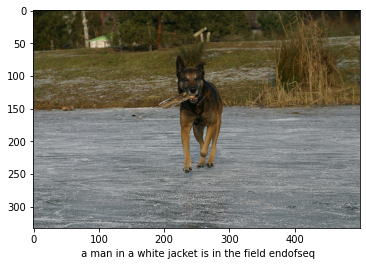

In [44]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)